# drivers in space

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 10

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

from Cell2D import Cell2DViewer

from matplotlib import rc
rc('animation', html='html5')

In [564]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_speed(self, d):
        self.speed += 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

In [568]:
class Highway:
    
    speed_limit = 40.0
    
    def __init__(self, n=10, size=1000, eps=0.01, constructor=Driver):
        self.size = size
        self.eps = eps
        locs = np.linspace(0, size, n, endpoint=False)
        locs.sort()
        self.drivers = [constructor(loc) for loc in locs]
        
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        for driver in self.drivers:
            d = self.distance(driver)
            driver.choose_speed(d)
            self.move(driver)
            
    def move(self, driver):
        # add random noise to speed
        driver.speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it under the speed limit
        if driver.speed > self.speed_limit:
            driver.speed = self.speed_limit
        
        # if current speed would collide with next driver, stop
        d = self.distance(driver)
        if driver.speed > d:
            driver.speed = 0
        
        # update loc
        driver.loc += driver.speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        d = driver.next.loc - driver.loc
        # fix wraparound
        if d < 0:
            d += self.size
        return d
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])

In [571]:
class HighwayViewer(Cell2DViewer):
    """Generates visualization and animation of SugarScape."""
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_drivers()
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def draw_drivers(self):
        """Plots the drivers.
        """
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points = plt.plot(xs, ys, '.', color='blue', markersize=20)[0]
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        xs *= 0.9
        ys *= 0.9
        self.stopped = plt.plot(xs, ys, 'x', color='red')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points.set_data(np.array([xs, ys]))
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        self.stopped.set_data(np.array([xs, ys]) * 0.9)
        return self.points,
    
    def get_coords(self, drivers):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        scale = 2 * np.pi / self.viewee.size
        
        locs = np.array([driver.loc for driver in drivers])
        xs = np.cos(locs * scale)
        ys = np.sin(locs * scale)
        return xs, ys

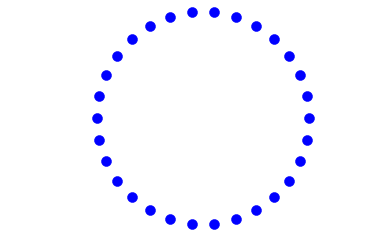

In [572]:
highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)
anim = viewer.animate(frames=600, interval=200)

In [573]:
anim

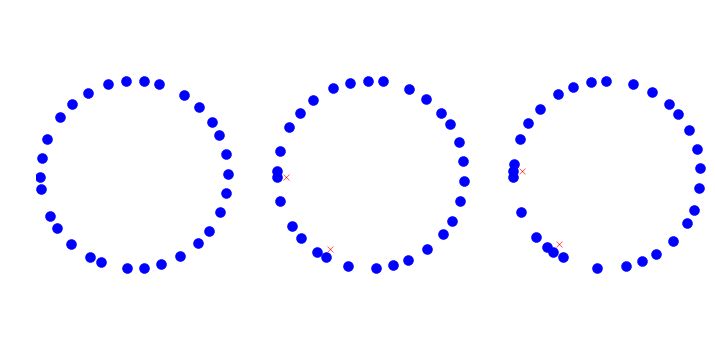

In [574]:
RandomSeed(22)

highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)

thinkplot.preplot(cols=3)
for i in range(16):
    highway.step()
viewer.draw()

thinkplot.subplot(2)
for i in range(1):
    highway.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(1):
    highway.step()
viewer.draw()
    

In [580]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

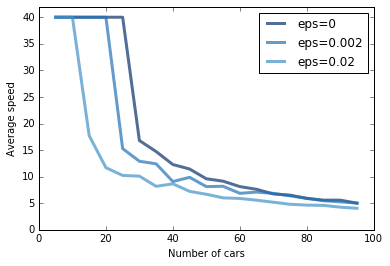

In [581]:
RandomSeed(20)

for eps in [0, 0.002, 0.02]:
    xs, ys = run_simulation(eps)
    thinkplot.plot(xs, ys, label='eps=%g' % eps)
    
thinkplot.config(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

In [609]:
class IdealDriver(Driver):
    def choose_speed(self, d):
        self.speed = d

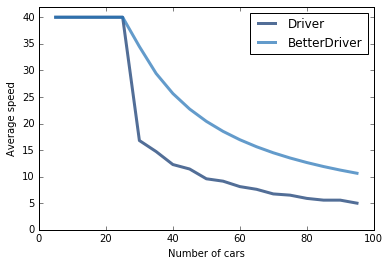

In [611]:
for constructor in [Driver, BetterDriver]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    thinkplot.plot(xs, ys, label=constructor.__name__)
    
thinkplot.config(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

In [ ]:
# Figure out the average speed as a function of n and try to go that speed.

## Boids